## 1. OCR 서비스 기획 
- 서비스명: 영화포스터 OCR 
- 서비스개요
    - 영화포스터에서 영화명, 감독, 주연배우 등의 텍스트를 인식하여 영화리스트에 등록하는 서비스 
    - 개인의 취향별 소장하고 싶은 영화, 향후 볼 영화, 친구에게 추천할 영화 등의 리스트를 만들어 관리할 수 있음

## 2. OCR 테스트 
### 2.1 Google OCR API

In [1]:
import os
 
img_dir = os.getenv('HOME')+'/aiffel/lms_project_dataset/EP18'
file_list = os.listdir(img_dir)
file_list.remove('.ipynb_checkpoints')
file_list

['Pulp_Fiction.png',
 'Red_White_Blue.png',
 'Back_to_the_Future.png',
 'Raiders_of_the_Lost_Ark.png',
 'King_Kong.png',
 'Gravity.png',
 'Jurassic_Park.png']

In [2]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [3]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'
# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file in file_list:
    print(f'[{file}]')
    detect_text(os.path.join(img_dir, file))
    print()

[Pulp_Fiction.png]
Texts:

"(WINNER BEST PICTURE-1994 CANNES
PULPFICTION
a Quentin Larantino film
10
pmoducal l
Lawrence Bender
JOHN TRAVOLTA
SAMUEL L. JACKSON
UMA THURMAN
HARVEY KEITEL
TIM ROTH
AMANDA PLUMMER
MARIA de MEDEIROS
VING RHAMES
ERIC STOLTZ
ROSANNA ARQUETTE
. CHRISTOPHER WALKEN
and
BRUCE WILLIS
AMAX EHAMS n A BANI APAAI JERSEY FRMS ENTN ARANT PE VI KAR onika
CN BEESY EMAN
HO NAN A ASO0SALY MEKKE RO na ANE SELA
SIACEY SHERSNTA TARANIN & ROSER AARY LAARENCE BER N ENTIN TARANTNE
MIRAMAX
R
EI N MCAR A
"

"(WINNER"

"BEST"

"PICTURE-1994"

"CANNES"

"PULPFICTION"

"a"

"Quentin"

"Larantino"

"film"

"10"

"pmoducal"

"l"

"Lawrence"

"Bender"

"JOHN"

"TRAVOLTA"

"SAMUEL"

"L."

"JACKSON"

"UMA"

"THURMAN"

"HARVEY"

"KEITEL"

"TIM"

"ROTH"

"AMANDA"

"PLUMMER"

"MARIA"

"de"

"MEDEIROS"

"VING"

"RHAMES"

"ERIC"

"STOLTZ"

"ROSANNA"

"ARQUETTE"

"."

"CHRISTOPHER"

"WALKEN"

"and"

"BRUCE"

"WILLIS"

"AMAX"

"EHAMS"

"n"

"A"

"BANI"

"APAAI"

"JERSEY"

"FRMS"

"ENTN"

"ARANT"


### 2.2 keras-ocr

In [4]:
import matplotlib.pyplot as plt
import keras_ocr
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [5]:
images = [keras_ocr.tools.read(os.path.join(img_dir, file)) for file in file_list]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, file)]) for file in file_list]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


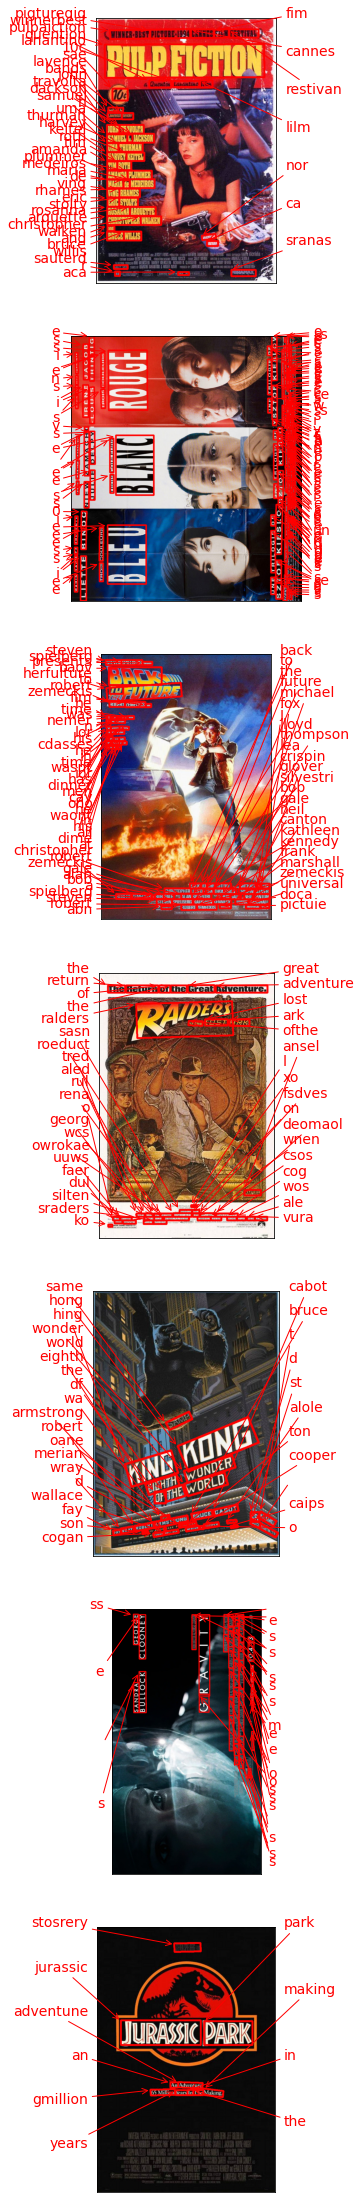

In [6]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 2.3 Tesseract

In [7]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

def recognize_images(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")

            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1

    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [8]:
save_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract_cropped'

for file in file_list:
    print(f'[{file}]')
    try:
        recognize_images(os.path.join(img_dir, file), save_dir)
    except:
        print(f'Cannot recognize characters from {file}')

[Pulp_Fiction.png]

Done
[Red_White_Blue.png]
Cannot recognize characters from Red_White_Blue.png
[Back_to_the_Future.png]
moth ie

iis

'

aeil

bi

ith ella meee

CHRISTOPHER

ait

teas a

HUMPSDON -

Bina

N GL

eas:

ae,

UBER

Aa")

ab

aN

ibis)

Olas

oa tO

AN SIL

VESTRI

een >i 0):'

ois

VS ee ae)

TEVEN

SPIELBERG

KATHLEEN KE

NNEDY — FRAN

ue elae

a

'VERSAL Picture


Done
[Raiders_of_the_Lost_Ark.png]
The


of

the

Great

Adventure.


Done
[King_Kong.png]
-

Done
[Gravity.png]
Cannot recognize characters from Gravity.png
[Jurassic_Park.png]
JURASSIC PARK

An Ad

Ses atiae

>.

Orit

ots

tT

ai.

ME Letira

Done


## 3. 테스트 결과 분석

In [9]:
def compare_ocr(file):
    print('[keras-ocr]')
    idx = file_list.index(file)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    print('\n[Google OCR]')
    detect_text(os.path.join(img_dir, file))
    print('\n[Tesseract]')
    recognize_images(os.path.join(img_dir, file), save_dir)

### 3.1 정형화된 영화 포스터 
- 3방법 모두 영화 제목은 정확히 맞췄으나, 감독이름, 세부 항목에 대해서 Keras는 조금 부정확했고, Google은 감독이름은 아예 인식하지 못했다. Tesseract는 거의 인식하지 못하였다. 
- 포스터의 색상이 배경색대비 명확한 제목은 인식이 잘되었지만, 다른 글자들은 인식하기 힘들었던 것 같다. 

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


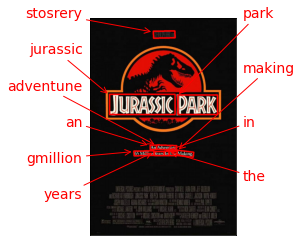


[Google OCR]
Texts:

"JURASSIC PARK
An Adventure
65 Million Years In The Making.
數ONE
MIKHIN
"

"JURASSIC"

"PARK"

"An"

"Adventure"

"65"

"Million"

"Years"

"In"

"The"

"Making."

"數"

"ONE"

"MIKHIN"
bounds: (287,920),(356,920),(356,927),(287,927)

[Tesseract]
JURASSIC PARK

An Ad

Ses atiae

>.

Orit

ots

tT

ai.

ME Letira

Done


In [10]:
compare_ocr('Jurassic_Park.png')

### 3.2 글자가 비스듬하게 쓰여진 영화 포스터 
- Google만 영화제목을 정확히 인식하였고, 나머지 두 방법은 모두 제목조차 정확히 인식하지 못하였음. 
- Tesseract는 포스터 자체를 인식하지 못하였다. 

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


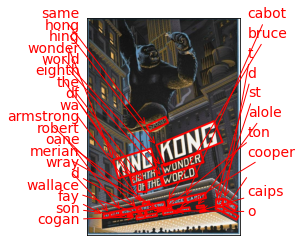


[Google OCR]
Texts:

"捐網
SAMPL
KING KONG
EIGHTH WONDER
OF THE WORLD
FAY WRAY ROBERT ARMSTRONG BRUCE CABOT
A CORPERSCNOEDRAEE PRODUCTION
Wah
ALAMO
28
ALOMC
FROM AN A DONCEVC BY EDGAR WALLACE AND MERIAN C. COOPER
PREE Sn I NE EI E NE R FR ISE FRSE atieree re
2012AUSTMT
"

"捐"

"網"

"SAMPL"

"KING"

"KONG"

"EIGHTH"

"WONDER"

"OF"

"THE"

"WORLD"

"FAY"

"WRAY"

"ROBERT"

"ARMSTRONG"

"BRUCE"

"CABOT"

"A"

"CORPERSCNOEDRAEE"

"PRODUCTION"

"Wah"

"ALAMO"

"28"

"ALOMC"

"FROM"

"AN"

"A"

"DONCEVC"

"BY"

"EDGAR"

"WALLACE"

"AND"

"MERIAN"

"C."

"COOPER"

"PREE"

"Sn"

"I"

"NE"

"EI"

"E"

"NE"

"R"

"FR"

"ISE"

"FRSE"

"atieree"

"re"

"2012AUSTMT"
bounds: (481,693),(555,731),(549,742),(476,704)

[Tesseract]
-

Done


In [11]:
compare_ocr('King_Kong.png')

### 3.3 글자가 선명하지 않은 영화 포스터 
- Keras와 Google은 영화제목과 세부 내용을 비교적 정확히 인식하였고, Tesseract는 포스터 자체를 인식하지 못하였다.

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


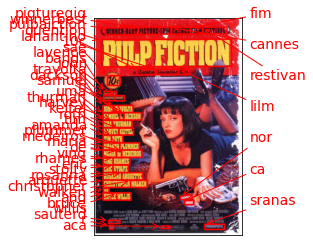


[Google OCR]
Texts:

"(WINNER BEST PICTURE-1994 CANNES
PULPFICTION
a Quentin Larantino film
10
pmoducal l
Lawrence Bender
JOHN TRAVOLTA
SAMUEL L. JACKSON
UMA THURMAN
HARVEY KEITEL
TIM ROTH
AMANDA PLUMMER
MARIA de MEDEIROS
VING RHAMES
ERIC STOLTZ
ROSANNA ARQUETTE
. CHRISTOPHER WALKEN
and
BRUCE WILLIS
AMAX EHAMS n A BANI APAAI JERSEY FRMS ENTN ARANT PE VI KAR onika
CN BEESY EMAN
HO NAN A ASO0SALY MEKKE RO na ANE SELA
SIACEY SHERSNTA TARANIN & ROSER AARY LAARENCE BER N ENTIN TARANTNE
MIRAMAX
R
EI N MCAR A
"

"(WINNER"

"BEST"

"PICTURE-1994"

"CANNES"

"PULPFICTION"

"a"

"Quentin"

"Larantino"

"film"

"10"

"pmoducal"

"l"

"Lawrence"

"Bender"

"JOHN"

"TRAVOLTA"

"SAMUEL"

"L."

"JACKSON"

"UMA"

"THURMAN"

"HARVEY"

"KEITEL"

"TIM"

"ROTH"

"AMANDA"

"PLUMMER"

"MARIA"

"de"

"MEDEIROS"

"VING"

"RHAMES"

"ERIC"

"STOLTZ"

"ROSANNA"

"ARQUETTE"

"."

"CHRISTOPHER"

"WALKEN"

"and"

"BRUCE"

"WILLIS"

"AMAX"

"EHAMS"

"n"

"A"

"BANI"

"APAAI"

"JERSEY"

"FRMS"

"ENTN"

"ARANT"

"PE"

In [12]:
compare_ocr('Pulp_Fiction.png')

### 3.4 가로 영화 포스터(세로 텍스트)
- Google은 영화제목과 세부 내용을 비교적 정확히 인식하였고, Keras는 영화제목과 주연 등의 글자 위치는 정확히 찾았으나 글자 인식을 잘하지는 못함. Tesseract는 포스터 자체를 인식하지 못하였다.

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


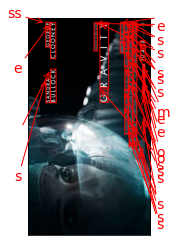


[Google OCR]
Texts:

"SANDRA
BULLOCK
GEORGE
CLOONEY
FROM DIRECTOR ALFONSO CUARÓN
GRAVIIY
WARNER BROS. PICTURES PRESENTS
AN ESPERANTO FILMOJ/HEYDAY FILMS PRODUCTION AN ALFONSO CUARÓN FILM SANDRA BULLOCK GEORGE CLOONEY "GRAVITY"
IEMIME VISUA EECIS TIM WEBBER EDTORS ALFONSO CUARÓN MARK SANGER PRAEH ANDY NICHOLSON PAORGERAAE EMMANUEL LUBEZKI, ASC, AM.
SCHIS DEFARMA NIKKI PENNY STEPHEN JONES WATW ALFONSO CUARÓN & JONÁS CUARÓ PROU ALFONSO CUARÓN DAVID HEYMAN DRETR ALFONSO CUARÓN
DIRECTOR
SUPERVISOR
DESIGNER
SEE TIN realD)3D AND IMAX 3D 10.4.13
gravity-movie.com
1
"

"SANDRA"

"BULLOCK"

"GEORGE"

"CLOONEY"

"FROM"

"DIRECTOR"

"ALFONSO"

"CUARÓN"

"GRAVIIY"

"WARNER"

"BROS."

"PICTURES"

"PRESENTS"

"AN"

"ESPERANTO"

"FILMOJ/HEYDAY"

"FILMS"

"PRODUCTION"

"AN"

"ALFONSO"

"CUARÓN"

"FILM"

"SANDRA"

"BULLOCK"

"GEORGE"

"CLOONEY"

""GRAVITY""

"IEMIME"

"VISUA"

"EECIS"

"TIM"

"WEBBER"

"EDTORS"

"ALFONSO"

"CUARÓN"

"MARK"

"SANGER"

"PRAEH"

"ANDY"

"NICHOLSON"

"PAORGERAAE"

"EMMANUE

SystemError: tile cannot extend outside image

In [13]:
compare_ocr('Gravity.png')

## 4. 결론 
- Google이 3방법 중에서 가장 정확하게 영화제목이나 주연배우 등을 인식하였음. Keras는 글자의 위치를 잡는 것은 정확했으나 글자를 인식하는 부분에서 조금 부족한 면이 있었던 것 같다. Tesseract는 누구나 글자가 명확하다고 느껴지는 포스터에 대해선 잘 인식하지만 이외의 포스터에 대해선 인식률이 급격히 낮아졌다. 